# Определение возраста покупателей

На размеченных данных ChaLearn Looking at People обучена нейросеть ResNet50 с добавленным полносвязным слоем, на валидационной выборке MAE = 6 лет

## Оглавление

* [Исследовательский анализ данных](#1)
    * [Распределение возрастов в выборке](#1.1)
    * [Первые 15 фотографий](#1.2)
    * [Промежуточный вывод](#1.3)
* [Обучение модели](#2)
    * [Код модели](#2.1)
    * [Работа модели](#2.2)
* [Вывод](#3)

<a id='1'></a>
## Исследовательский анализ данных

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
%pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import seaborn as sns
sns.set_theme()

In [7]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)

In [9]:
features.shape

(32, 224, 224, 3)

In [10]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


данные загрузились, все фотографии размечены

<a id='1.1'></a>
### Распределение возрастов в выборке

Text(0, 0.5, 'count')

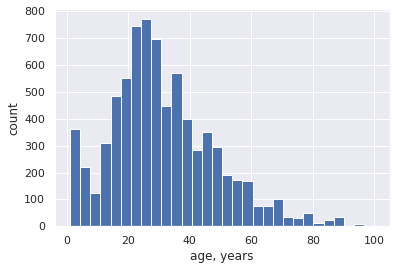

In [13]:
labels.real_age.hist(bins = 30)
plt.xlabel('age, years')
plt.ylabel('count')

In [14]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [15]:
labels[labels['real_age'] == 1]

,file_name,real_age
13,000013.jpg,1
21,000021.jpg,1
30,000030.jpg,1
40,000040.jpg,1
53,000053.jpg,1
...,...,...
7542,007564.jpg,1
7546,007568.jpg,1
7574,007596.jpg,1
7577,007599.jpg,1


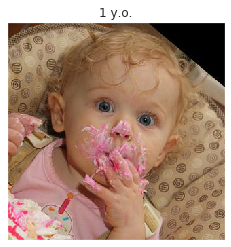

In [16]:
image = Image.open('/datasets/faces/final_files/000013.jpg')
array = np.array(image)
plt.imshow(array)
plt.xticks([])
plt.yticks([])
plt.title('1 y.o.')
plt.show()

<a id ="1.2"></a>
### Первые 15 фотографий

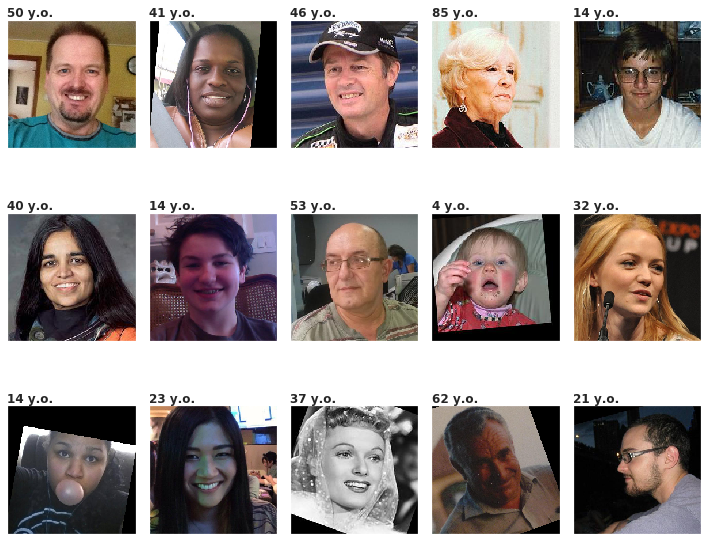

In [17]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.text(0, -5, str(target[i]) + ' y.o.', fontweight = 'bold')
    plt.tight_layout()

<a id ="1.3"></a>
### Промежуточный вывод

* Выборка неоднородно покрывает возрастной диапазон потенциальных покупателей. Большая часть лежит в интервале 20-40 лет, гораздо меньше фотографий людей пожилого возраста и детей. При этом в данных есть непропорционально много фотографий детей годовалого возраста, что возможно связано с ошибкой в разметке данных. Из-за неоднородного распределения возрастов в выборке следует ожидать у модели меньшей точности на фотографиях близких к границам распределения.


* Часть фотографий черно-белая, при построении модели предлагаю это не учитывать


* Размер выборки достаточен (7591) для применения ResNet. Уберем у ResNet50 верхние слои, добавим полносвязный слой из 100 нейронов, слой GlobalAveragePooling2D, и итоговый нейрон с relu активацией, который и будет предсказывать возраст


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>аааа, вот выводы. ОК!.<br>

Добавлю ещё по сами картинкам:<br>
1) В датасете есть старые и черно-белые фотографии (ты как раз об этом упомянул). Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость<br>

2) В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона<br>

3) В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев<br>

4) В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев<br>

5) В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба<br>

<a id ="2"></a>
## Обучение модели

<a id ="2.1"></a>
### Код модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
 
 
def load_train(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.)
        
    df = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(250, 250),
        batch_size=32,
        subset='training',
	class_mode='raw',
        seed=12345)
 
    return train_datagen_flow
    
def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
    
    df = pd.read_csv(path + 'labels.csv')
    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(250, 250),
        batch_size=32,
        subset='validation',
	class_mode='raw',
        seed=12345)
 
    return val_datagen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=(250, 250, 3),
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(Dense(100, activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model


```

<a id ="2.2"></a>
### Работа модели

```

2021-05-15 18:12:37.451180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-05-15 18:12:37.953113: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-05-15 18:12:51.758123: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-15 18:12:52.414136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-05-15 18:12:52.414234: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-15 18:12:52.414271: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-15 18:12:52.690644: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-05-15 18:12:52.785022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-05-15 18:12:53.732666: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-05-15 18:12:53.825373: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-05-15 18:12:53.825446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-05-15 18:12:53.828900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-05-15 18:12:53.829354: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-05-15 18:12:54.012143: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2021-05-15 18:12:54.017890: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x53d1cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-15 18:12:54.017922: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-05-15 18:12:54.376269: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5457d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-05-15 18:12:54.376308: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2021-05-15 18:12:54.378420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-05-15 18:12:54.378486: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-15 18:12:54.378498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-15 18:12:54.378520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-05-15 18:12:54.378534: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-05-15 18:12:54.378545: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-05-15 18:12:54.378556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-05-15 18:12:54.378565: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-05-15 18:12:54.382173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-05-15 18:12:54.420663: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-15 18:13:01.398740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-05-15 18:13:01.398790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-05-15 18:13:01.398799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-05-15 18:13:01.415400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
2021-05-15 18:13:42.903313: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-15 18:13:47.371674: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 117s - loss: 223.8384 - mae: 11.0066 - val_loss: 423.1806 - val_mae: 15.5286
Epoch 2/15
178/178 - 42s - loss: 101.7358 - mae: 7.6335 - val_loss: 432.4591 - val_mae: 15.6748
Epoch 3/15
178/178 - 42s - loss: 71.2798 - mae: 6.4183 - val_loss: 310.2794 - val_mae: 12.9201
Epoch 4/15
178/178 - 42s - loss: 57.5979 - mae: 5.7912 - val_loss: 154.7686 - val_mae: 9.5807
Epoch 5/15
178/178 - 41s - loss: 50.7073 - mae: 5.3932 - val_loss: 88.4000 - val_mae: 7.0153
Epoch 6/15
178/178 - 42s - loss: 40.5365 - mae: 4.8078 - val_loss: 80.1920 - val_mae: 6.8647
Epoch 7/15
178/178 - 42s - loss: 34.0215 - mae: 4.4176 - val_loss: 85.9359 - val_mae: 6.9098
Epoch 8/15
178/178 - 43s - loss: 27.5938 - mae: 3.9826 - val_loss: 146.4904 - val_mae: 9.1051
Epoch 9/15
178/178 - 43s - loss: 24.2124 - mae: 3.7159 - val_loss: 81.6710 - val_mae: 6.9142
Epoch 10/15
178/178 - 42s - loss: 21.6694 - mae: 3.5171 - val_loss: 75.6323 - val_mae: 6.5279
Epoch 11/15
178/178 - 42s - loss: 18.2677 - mae: 3.2606 - val_loss: 72.8383 - val_mae: 6.4807
Epoch 12/15
178/178 - 42s - loss: 18.3405 - mae: 3.2332 - val_loss: 70.9905 - val_mae: 6.3183
Epoch 13/15
178/178 - 42s - loss: 15.0810 - mae: 2.9755 - val_loss: 65.3162 - val_mae: 6.0777
Epoch 14/15
178/178 - 42s - loss: 15.5191 - mae: 2.9763 - val_loss: 70.3778 - val_mae: 6.2388
Epoch 15/15
178/178 - 42s - loss: 13.5832 - mae: 2.7628 - val_loss: 76.7689 - val_mae: 6.7166
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 76.7689 - mae: 6.7166
Test MAE: 6.7166

```

<a id ="3"></a>
## Вывод

* Предобученная ResNet50 с добавленным полносвязным слоем из 100 нейронов смогла достигнуть целевой метрики MAE (< 8 лет) за 5 эпох.

* На 15 эпохе MAE на валидационной выборке составила 6.7 лет, однако сеть сильно переобчучилась

* Время обучения оказалось вполне приемлимым, сервер справился за 12 минут